In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.nn import convolution

In [13]:
N = 100
dt = 0.001
h = 1

In [14]:
_U = np.zeros(shape=(N, N, 2))
_I = np.zeros(shape=(N, N, 2))
_B = np.zeros(shape=(N, N, 1))
_p = np.zeros(shape=(N, N, 1))

_R = 10000 * np.ones(shape=(N, N, 1))
_eps = np.ones(shape=(N, N, 1))
_mu = np.ones(shape=(N, N, 1))

In [15]:
X = np.array([[0, 0, 0], [1, -1, 0],[0, 0, 0]])
Y = np.array([[0, 1, 0], [0, -1, 0],[0, 0, 0]])
_continuity_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,0,3)

In [16]:
X = np.array([[0, 0, 0], [0, 1, 0],[0, -1, 0]])
Y = np.array([[0, 0, 0], [0, -1, 1],[0, 0, 0]])
_faraday_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,0,3) / h ** 2

In [17]:
X = np.array([[0, 1, 0], [0, -1, 0],[0, 0, 0]])
Y = np.array([[0, 0, 0], [-1, 1, 0],[0, 0, 0]])
_ampere_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,3,0) * h

In [18]:
Y

array([[ 0,  0,  0],
       [-1,  1,  0],
       [ 0,  0,  0]])

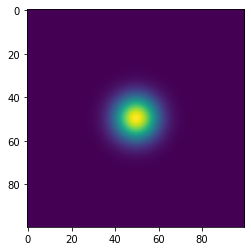

In [19]:
x = np.linspace(0, 10, N)
mesh = np.stack(np.meshgrid(x, x))

_B = np.exp(-np.sum(np.square(mesh-np.array([5,5]).reshape((2,1,1))), axis=0))

plt.imshow(_B)

In [20]:
_continuity_filter[:,:,0,0]

array([[ 0,  0,  0],
       [ 1, -1,  0],
       [ 0,  0,  0]])

In [21]:
_continuity_filter[:,:,1,0]

array([[ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  0]])

In [22]:
faraday_filter = tf.constant(_faraday_filter, name='faraday_filter', dtype=tf.float64)
ampere_filter = tf.constant(_ampere_filter, name='ampere_filter', dtype=tf.float64)
continuity_filter = tf.constant(_continuity_filter, name='continuity_filter', dtype=tf.float64)

eps = tf.constant(_eps.reshape((1, N, N, 1)), name='dielectricity', dtype=tf.float64)
mu = tf.constant(_mu.reshape((1, N, N, 1)), name='permitivity', dtype=tf.float64)
R = tf.constant(_R.reshape((1, N, N, 1)), name='resistance', dtype=tf.float64)
U = tf.Variable(_U.reshape((1, N, N, 2)), name='e_field', dtype=tf.float64)
I = tf.Variable(_I.reshape((1, N, N, 2)), name='current', dtype=tf.float64)
B = tf.Variable(_B.reshape((1, N, N, 1)), name='b_field', dtype=tf.float64)
p = tf.Variable(_p.reshape((1, N, N, 1)), name='charge_density', dtype=tf.float64)

In [23]:
for jter in range(10000):
    I = U / R
    dB = convolution(U, filters=faraday_filter, padding='SAME')
    dp = convolution(I, filters=continuity_filter, padding='SAME')
    dU = (convolution(B, filters=ampere_filter, padding='SAME') / eps / mu - I / eps)

    U.assign_add(dU * dt)
    B.assign_add(dB * dt)
    p.assign_add(dp * dt)


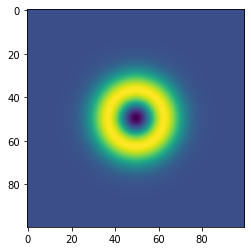

In [24]:
plt.imshow(np.squeeze(B.numpy()))

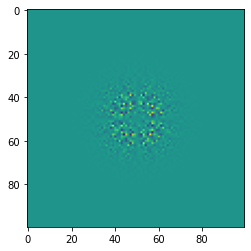

In [25]:
plt.imshow(np.squeeze(p.numpy()))

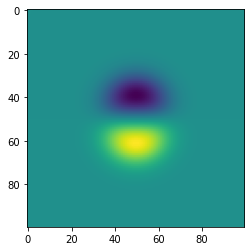

In [26]:
plt.imshow(np.squeeze((U).numpy())[:,:,0])

In [27]:
tf.squeeze(U)[50,50,0]

<tf.Tensor: shape=(), dtype=float64, numpy=-2.326816839889531e-16>

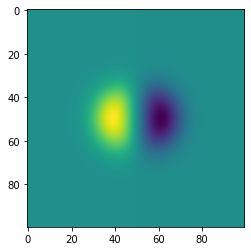

In [28]:
plt.imshow(np.squeeze(U.numpy())[:,:,1])

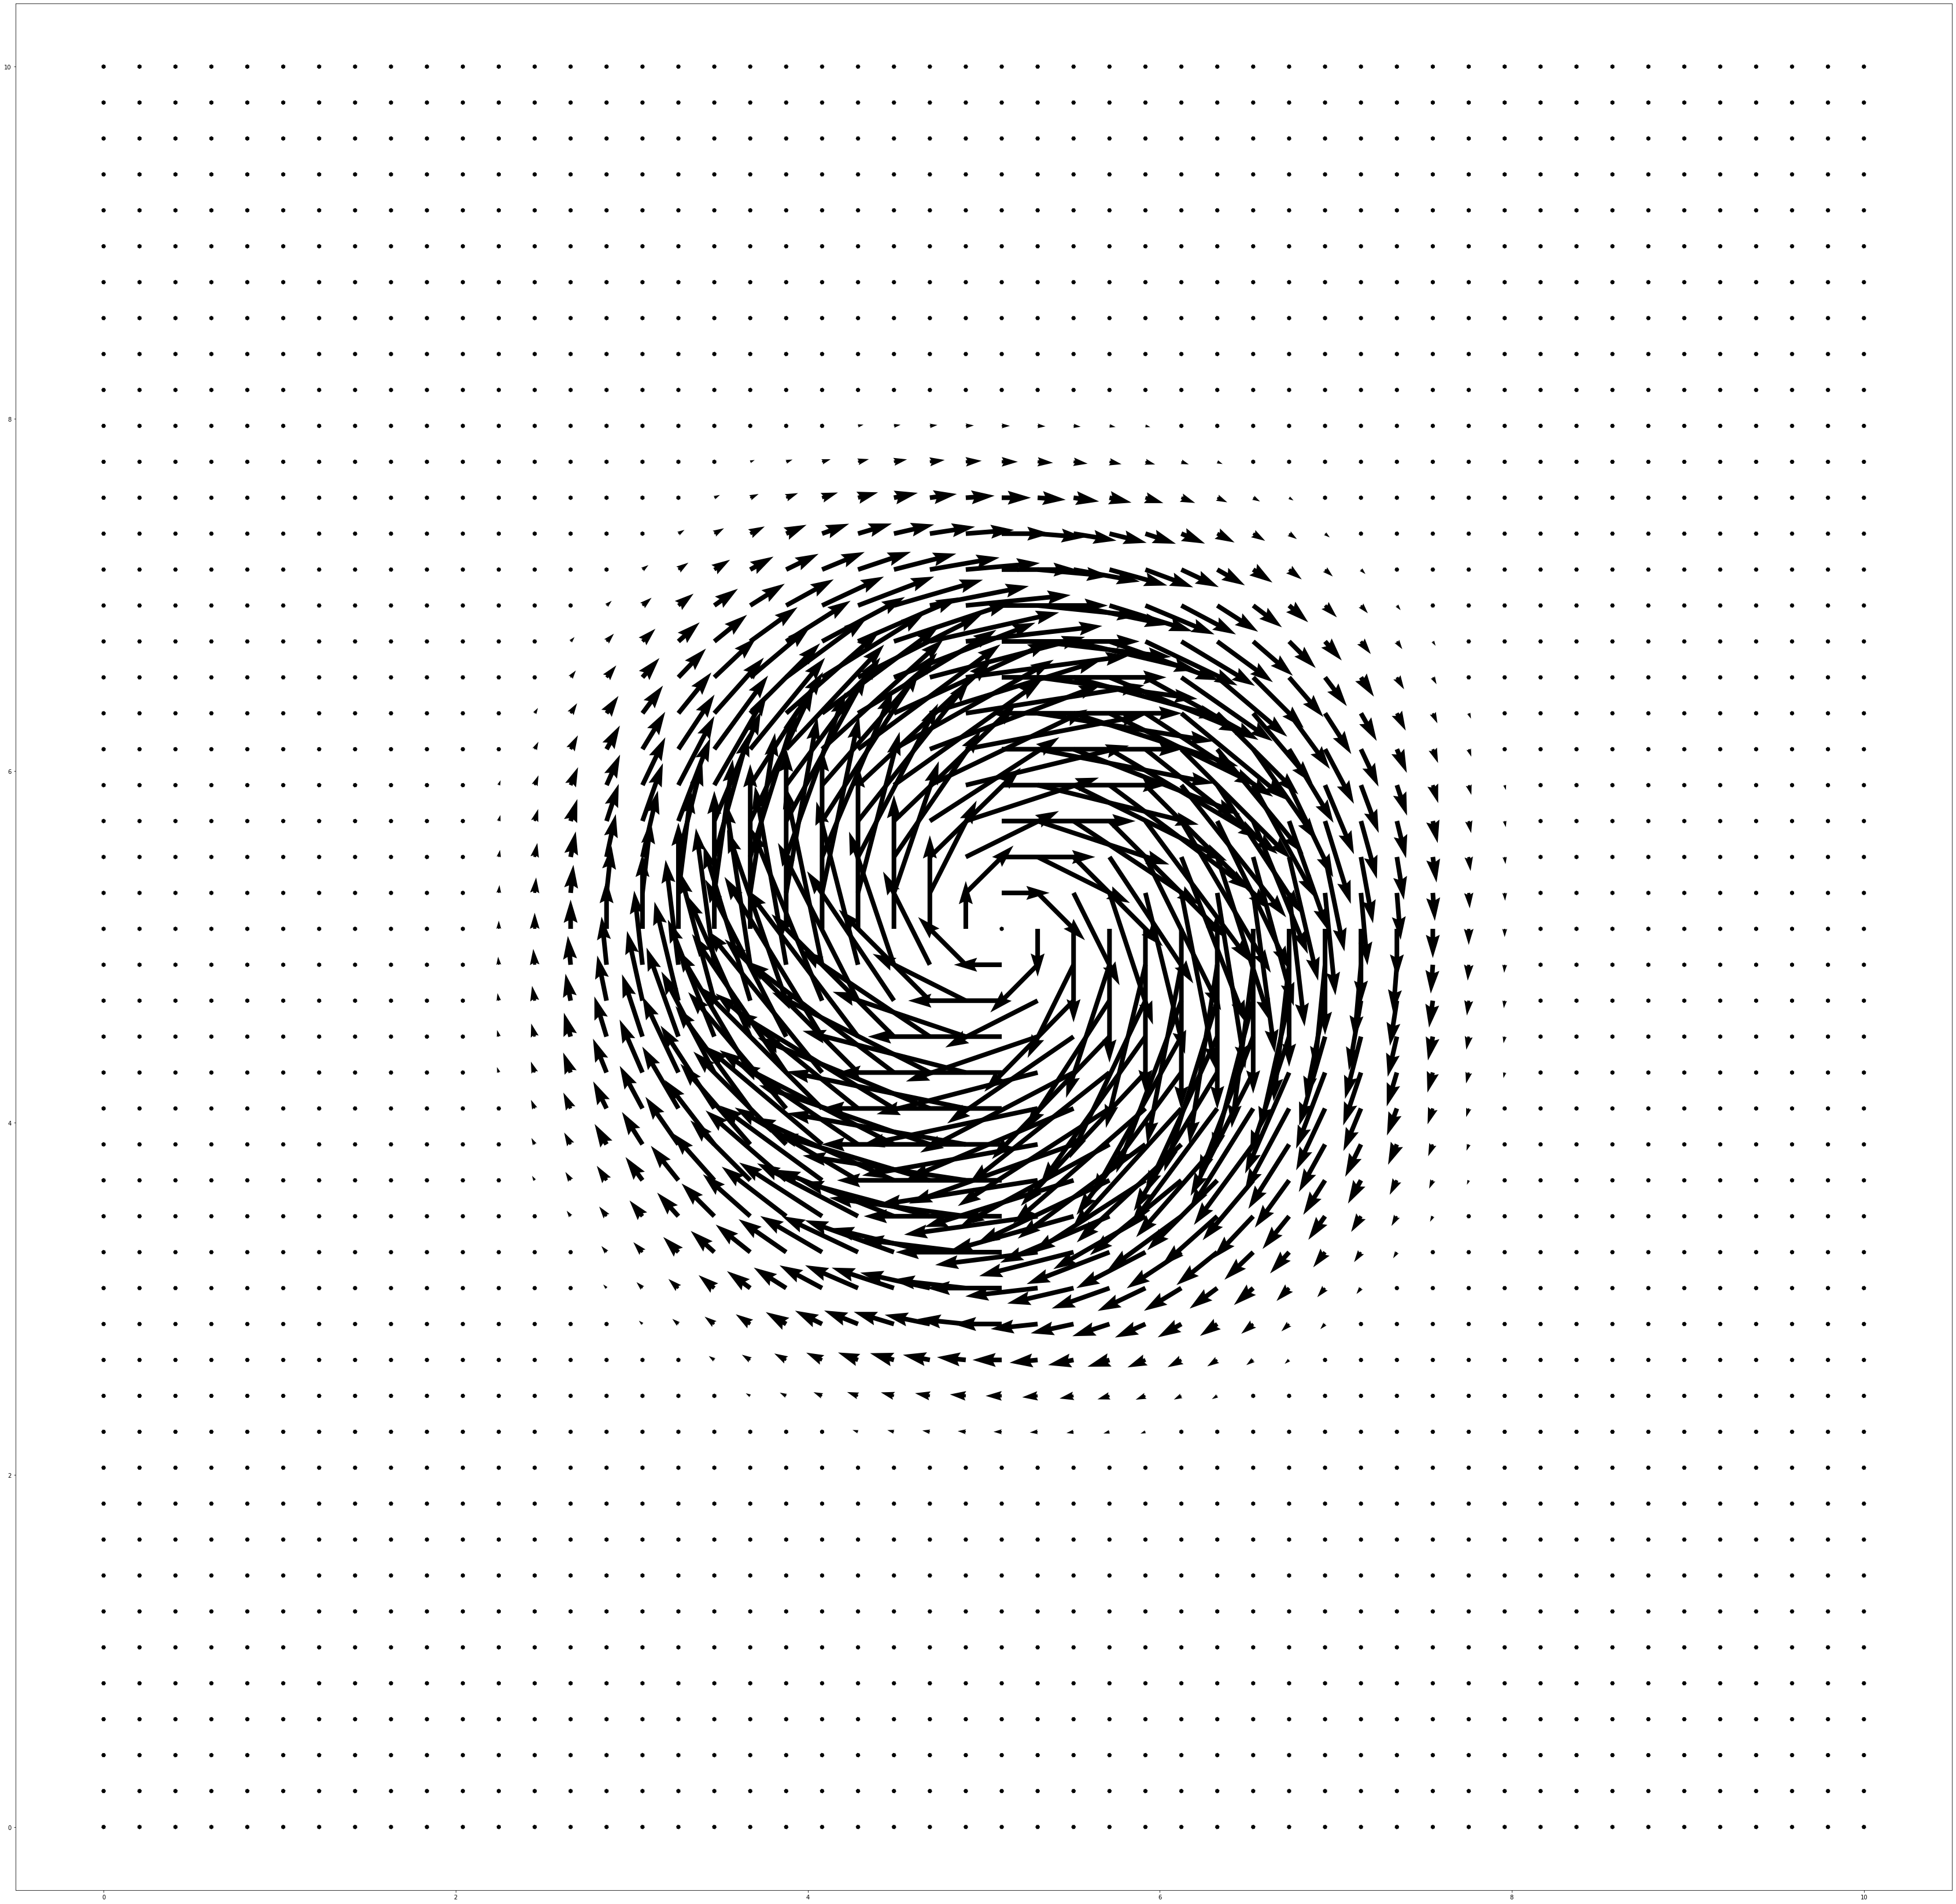

In [30]:
#fig, ax = plt.subplots()
v = np.squeeze(U.numpy())

plt.figure(figsize=(60, 60))
x_pos = 0
y_pos = 0
x_direct = 1
y_direct = 1
plt.axis('equal');
plt.quiver(np.linspace(0,10,50),np.linspace(0,10,50), v[::2,::2,0], v[::2,::2,1])

plt.show()